# 2.3 Complete Two-Towers Model

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from math import sqrt
from statistics import mean
from collections import Counter

We begin by importing the data and metadata we saved on the last project:

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)
test_df = pd.read_csv('../local_data/test_data.csv', header=0)
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

Extracting vocabularies. Note that categorical features whic contain numbers are casted to strings.

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
all_ages = [str(int(i)) for i in metadata['ages']]
all_occupations = [str(int(i)) for i in metadata['occupations']]
all_genres = metadata['genres']
title_emb_len = metadata['title_emb_size']
na_value = metadata['string_na']

Converting to datasets. Note `genres` and `title_emb` are arrays of arrays.

In [4]:
def convert_to_dataset(df):
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df)
test_dataset = convert_to_dataset(test_df)

2021-11-13 12:47:27.876358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We now implement the two-tower model using Tensorflow Recommenders; note the model inherits from `tfrs.models.Model` and not `tf.keras.Model`.

### Model architecture 

The user tower will be built upon the following features:

* `user` (the user ID)
* `city`
* `state`
* `age`
* `occupation`
* `gender`
* `hour`, `day` and `month`

The first five features are categorical, and therefore fed into a combination of `StringLookup` and `Embedding` layers, transforming them to learned embedding vectors, and will therefore require the list of values we saved in the metadata (the vocabulary). The other featuers can be inserted as they are.

The movie model contains the following features:

* `movie` (the movie ID)
* `title`
* `genres`
* `movie_year`

Here only `movie` requires the combination of `StringLookup` and `Embedding` layers.

Each tower has two `Dense` layers on top of the inputs, with 100 and 50 nodes each. We than concatenate the two towers, and add three `Dense` layers on top, with 100, 50 and 20 nodes each, finishing with a single node as the output.

### Activation functions

I used `relu` everywhere, except for one case - right agter the `title` input. The title embeddings are constant, and not learned like the rest. The title embeddings contain negative numbers, and these values will be lost if handled by `relu`. Therefore, I added a `softmax` layer on top of the `title` input, to make sure all inputs are converted to non-negative numbers.

In [5]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3
        
        # User tower
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        
        # Movie tower
        
        self.movie_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=1)
        
        self.title_input = tf.keras.Input(shape=(title_emb_len,), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(len(all_genres),), name='genres_input')
        self.year_input = tf.keras.Input(shape=(1,), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_emb, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        
        # Combining towers
        
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([self.user_last_layer, self.movie_last_layer])
        self.towers_dense1 = tf.keras.layers.Dense(40, activation='relu', name='towers_dense1')(self.towers_multiplied)
        self.towers_dense2 = tf.keras.layers.Dense(20, activation='relu', name='towers_dense2')(self.towers_dense1)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense2)
        
        # Model definition
        
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
                                            'movie': self.movie_input,
                                            'title': self.title_input,
                                            'genres': self.genres_input,
                                            'year': self.year_input
                                            }, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"],
                           'movie': tf.strings.as_string(features["movie"]),
                           'title': features["title_emb"],
                           'genres': features["genres"],
                           'year': features["movie_year"]
                           })
    
    def compute_loss(self, features, **kwargs):
        return self.task(labels=features["rating"], predictions=self(features))

Training:

In [6]:
model = RatingPredictionModel()
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(2e-3, decay_steps=4000, decay_rate=0.95)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=5)
model.fit(cached_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
96/96 [==============================] - 16s 156ms/step - root_mean_squared_error: 17.0857 - loss: 286.0091 - regularization_loss: 0.0000e+00 - total_loss: 286.0091
Epoch 2/1000
96/96 [==============================] - 3s 27ms/step - root_mean_squared_error: 1.2943 - loss: 1.6829 - regularization_loss: 0.0000e+00 - total_loss: 1.6829
Epoch 3/1000
96/96 [==============================] - 3s 27ms/step - root_mean_squared_error: 1.2304 - loss: 1.5183 - regularization_loss: 0.0000e+00 - total_loss: 1.5183
Epoch 4/1000
96/96 [==============================] - 3s 27ms/step - root_mean_squared_error: 1.2027 - loss: 1.4488 - regularization_loss: 0.0000e+00 - total_loss: 1.4488
Epoch 5/1000
96/96 [==============================] - 3s 27ms/step - root_mean_squared_error: 1.1698 - loss: 1.3693 - regularization_loss: 0.0000e+00 - total_loss: 1.3693
Epoch 6/1000
96/96 [==============================] - 3s 27ms/step - root_mean_squared_error: 1.1462 - loss: 1.3136 - regularization_loss:

Let's test the model:

In [7]:
cached_test = test_dataset.batch(5000).cache()
model.evaluate(cached_test, return_dict=True)

11/11 [==============================] - 0s 39ms/step - root_mean_squared_error: 0.9846 - loss: 0.9477 - regularization_loss: 0.0000e+00 - total_loss: 0.9477


{'root_mean_squared_error': 0.9845906496047974,
 'loss': 0.8391626477241516,
 'regularization_loss': 0,
 'total_loss': 0.8391626477241516}

We've reached $RMSE = 0.98$.

Let's imitate a single prediction made:

In [8]:
x = {k:np.asarray([v]) for k,v in list(test_dataset.take(1).as_numpy_iterator())[0].items()}
print(f"Prediction for user {x['user'][0]} and movie {x['movie'][0]}: {model.predict(x)[0][0]:.2f} (rating: {x['rating'][0]})")

Prediction for user 6040 and movie 858: 3.97 (rating: 4)


Plotting and saving the model:

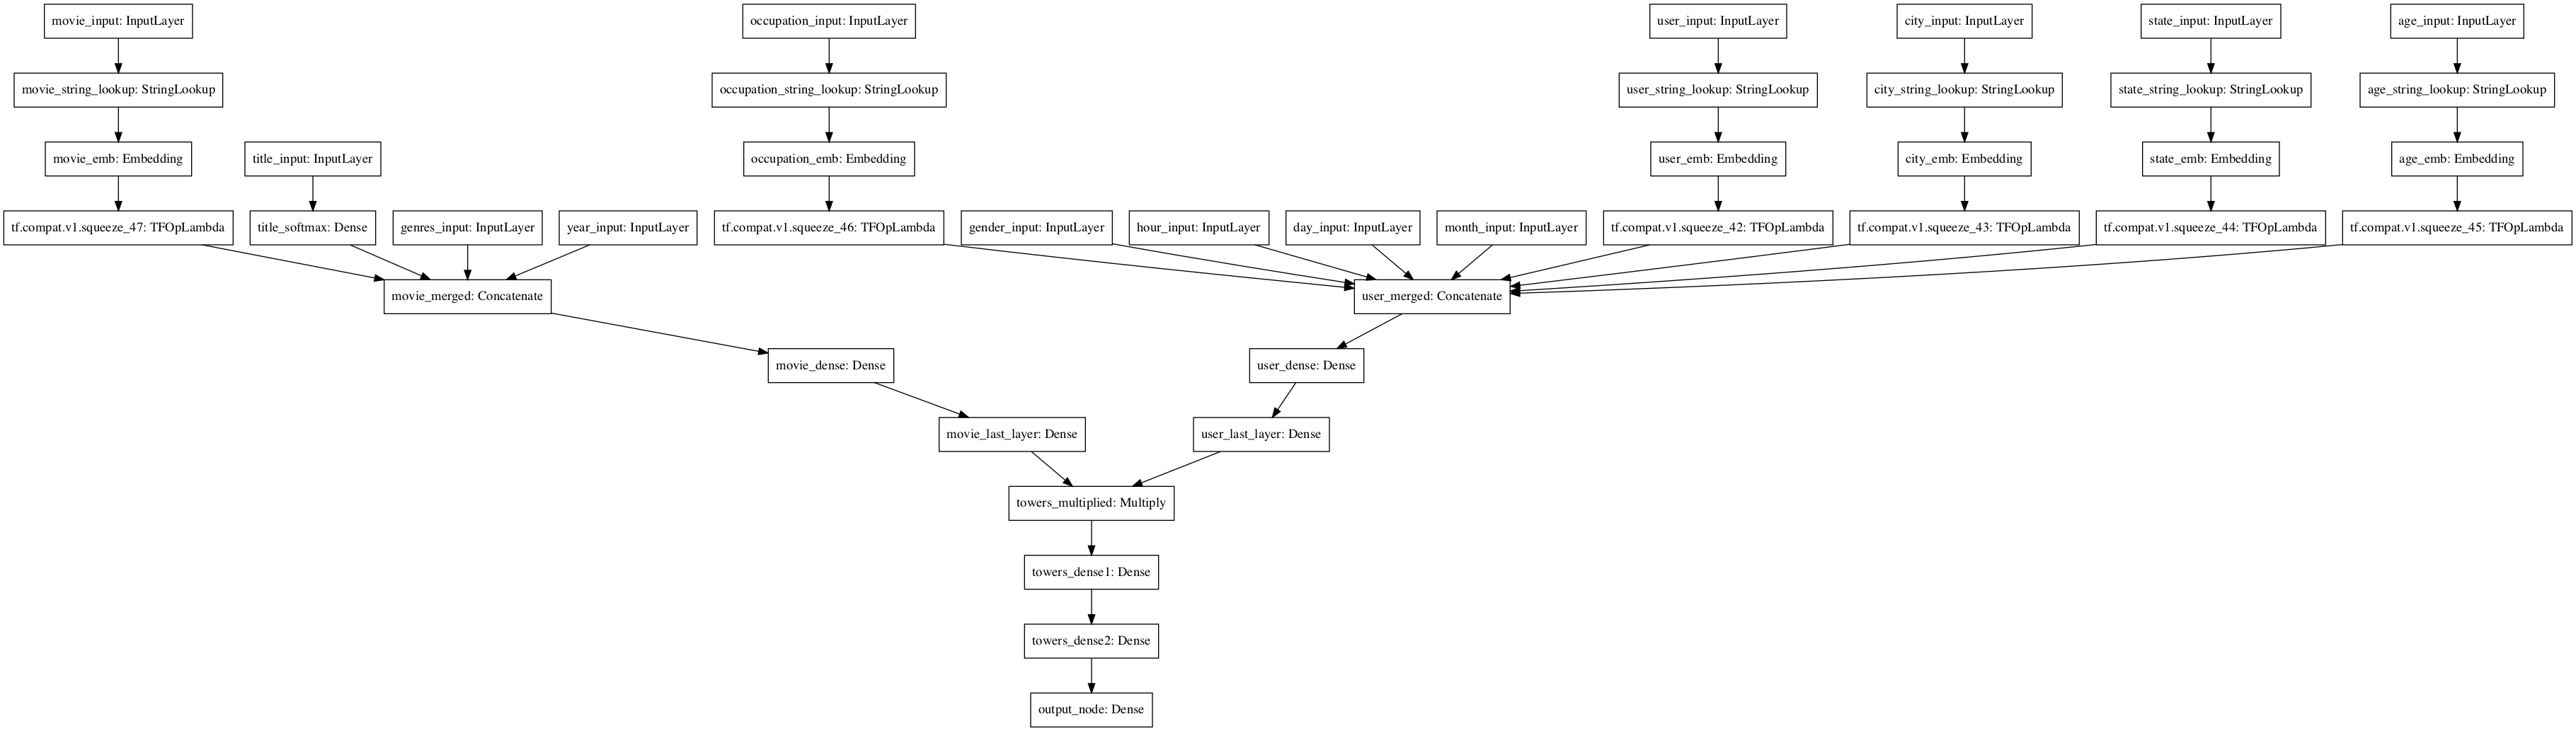

In [9]:
tf.keras.utils.plot_model(model.model, to_file="project_2_3.png")

In [10]:
model.model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
city_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
state_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
age_input (InputLayer)          [(None, 1)]          0                                            
____________________________________________________________________________________________

In [11]:
model.save_weights('weights_2_3/p23')